 # Homework 5 - opti 0 (original), 1 (L2), 2 (data augmentation), 3(dropout)
 ## Group 10

## Assignment 1 - Reviews

We review the homeworks for groups 15 and 32.

## Assignment 2 - CIFAR-10 Classification

In [39]:
# the necessary imports

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime as datetime
import tqdm
import keras_cv # install keras_cv with pip for data augmentation

### 2.1 Prepare the Dataset

In [40]:
def preprocess(dataset):

    # convert data from uint8 to float32
    dataset = dataset.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # flatten the images into vectors - we don't do this step for CNN, CNN layers expect standard image format input
    # dataset = dataset.map(lambda img, target: (tf.reshape(img, (-1,)), target))

    # input normalization, just bringing image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, target: ((img / 128.) - 1., target))

    # create one-hot targets with depth 10 since cifar 10 has 10 classes
    dataset = dataset.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    # cache
    dataset = dataset.cache()

    # shuffle, batch, prefetch
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(tf.data.AUTOTUNE) 

    # return preprocessed dataset
    return dataset

In [41]:
def preprocess_aug(dataset, augmentation):

    # convert data from uint8 to float32
    dataset = dataset.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # flatten the images into vectors - we don't do this step for CNN, CNN layers expect standard image format input
    # dataset = dataset.map(lambda img, target: (tf.reshape(img, (-1,)), target))

    # input normalization, just bringing image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, target: ((img / 128.) - 1., target))

    # create one-hot targets with depth 10 since cifar 10 has 10 classes
    dataset = dataset.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    # cache
    dataset = dataset.cache()

    # shuffle, batch, prefetch
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(tf.data.AUTOTUNE) 

    if augmentation:
        dataset = dataset.map(lambda x,y : (augmentation_model(x), y),num_parallel_calls=tf.data.AUTOTUNE)

    # return preprocessed dataset
    return dataset

In [42]:
(train_ds, test_ds), ds_info = tfds.load ('cifar10', split =['train', 'test'], as_supervised = True, with_info = True)

# print("ds_info: \n", ds_info)

# visualize a sample of the dataset
# tfds.show_examples(train_ds, ds_info)

In [43]:
train_dataset = preprocess(train_ds)
test_dataset = preprocess(test_ds)

In [53]:
class ConvModel(tf.keras.Model):
    def __init__(self, L1_reg=0, L2_reg=0, dropout_rate=0, batch_norm=False):
        super().__init__()
        
        if L2_reg >= 0: # L2 is the default
            kernel_regularizer=tf.keras.regularizers.L2(L2_reg)
        elif L1_reg > 0:
            kernel_regularizer=tf.keras.regularizers.L2(L1_reg)
        else:
            None

        self.dropout_rate = dropout_rate
        if self.dropout_rate:
            self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
            
        self.layer_list = [tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer), 
            tf.keras.layers.Conv2D(32, 3,activation="relu", kernel_regularizer=kernel_regularizer),
            tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer),
            tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(10, activation="softmax", kernel_regularizer=kernel_regularizer)]
        if batch_norm:
            
                self.layer_list = [tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer), 
                                   tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(32, 3,activation="relu", kernel_regularizer=kernel_regularizer),
                                   tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer),
                                   tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=kernel_regularizer),
                                   tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Flatten(),
                                   #tf.keras.layers.BatchNormalization(),
                                    tf.keras.layers.Dense(10, activation="softmax", kernel_regularizer=kernel_regularizer)]
        # metrics to update
        self.frobenius_metric = tf.keras.metrics.Mean(name="total_frobenius_norm")
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        self.accuracy_metric = tf.keras.metrics.CategoricalAccuracy(name="accuracy")
        
    def call(self, x, training=False):
        for layer in self.layer_list[:-1]:
            x = layer(x)
            if self.dropout_rate:
                x = self.dropout_layer(x, training)
        
        return self.layer_list[-1](x)
    
    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()
            
    def compute_frobenius(self):
        frobenius_norm = tf.zeros((1,))
        for var in self.trainable_variables:
            frobenius_norm += tf.norm(var, ord="euclidean")
        return frobenius_norm
    
    @tf.function
    def train_step(self, data):
        x, target = data
        with tf.GradientTape() as tape:
            prediction = self(x, training=True)
            loss = self.compiled_loss(target, prediction, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.frobenius_metric.update_state(self.compute_frobenius())
        self.loss_metric.update_state(loss)
        self.accuracy_metric.update_state(target, prediction)
        
        return {metric.name: metric.result() for metric in self.metrics}
    
    @tf.function
    def test_step(self, data):
        x, target = data
        prediction = self(x, training=False)
        loss = self.compiled_loss(target, prediction, regularization_losses=self.losses)
        
        self.frobenius_metric.update_state(self.compute_frobenius())
        self.loss_metric.update_state(loss)
        self.accuracy_metric.update_state(target, prediction)
        
        return {metric.name: metric.result() for metric in self.metrics}

## 0. Training the model without any extra regularization (original)

In [45]:
model = ConvModel()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="adam")
original = model.fit(train_dataset, validation_data=test_dataset, epochs=2)#15)

Epoch 1/2
1563/1563 [==============================] - 113s 71ms/step - loss: 1.4097 - total_frobenius_norm: 34.3878 - accuracy: 0.4940 - val_loss: 1.1897 - val_total_frobenius_norm: 42.0127 - val_accuracy: 0.5792
Epoch 2/2
1563/1563 [==============================] - 115s 74ms/step - loss: 1.0279 - total_frobenius_norm: 48.0977 - accuracy: 0.6399 - val_loss: 1.0185 - val_total_frobenius_norm: 53.6661 - val_accuracy: 0.6442


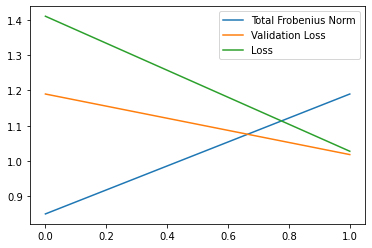

In [46]:
plt.plot(original.history["total_frobenius_norm"]/np.max(original.history["total_frobenius_norm"]) * np.max(original.history["val_loss"]))
plt.plot(original.history["val_loss"])
plt.plot(original.history["loss"])
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
plt.savefig("convnet_original")
plt.show()

## 1. Training the same model with L1 regularization (lassoReg)

In [50]:
model = ConvModel(L1_reg=0.001)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="adam")
lassoReg = model.fit(train_dataset, validation_data=test_dataset, epochs=2)#15)

Epoch 1/2
1563/1563 [==============================] - 131s 83ms/step - loss: 1.5295 - total_frobenius_norm: 25.1115 - accuracy: 0.5013 - val_loss: 1.2979 - val_total_frobenius_norm: 26.7853 - val_accuracy: 0.5954
Epoch 2/2
1563/1563 [==============================] - 119s 76ms/step - loss: 1.2447 - total_frobenius_norm: 27.5232 - accuracy: 0.6225 - val_loss: 1.2024 - val_total_frobenius_norm: 28.1859 - val_accuracy: 0.6452


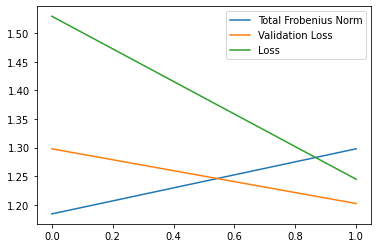

In [51]:
plt.plot(lassoReg.history["total_frobenius_norm"]/np.max(lassoReg.history["total_frobenius_norm"]) * np.max(lassoReg.history["val_loss"]))
plt.plot(lassoReg.history["val_loss"])
plt.plot(lassoReg.history["loss"])
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
plt.savefig("convnet_L1")
plt.show()

## 2. Training the same model with L2 regularization (ridgeReg)

In [47]:
model = ConvModel(L2_reg=0.001)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="adam")
ridgeReg = model.fit(train_dataset, validation_data=test_dataset, epochs=2)#15)

Epoch 1/2
1563/1563 [==============================] - 124s 79ms/step - loss: 1.5341 - total_frobenius_norm: 24.1728 - accuracy: 0.4987 - val_loss: 1.3668 - val_total_frobenius_norm: 25.7007 - val_accuracy: 0.5729
Epoch 2/2
 570/1563 [=========>....................] - ETA: 1:12 - loss: 1.3092 - total_frobenius_norm: 25.9346 - accuracy: 0.5990

KeyboardInterrupt: 

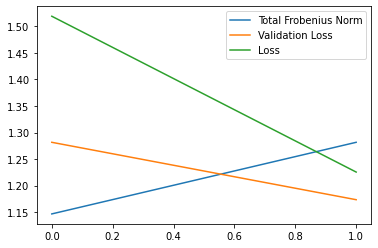

In [ ]:
plt.plot(ridgeReg.history["total_frobenius_norm"]/np.max(ridgeReg.history["total_frobenius_norm"]) * np.max(ridgeReg.history["val_loss"]))
plt.plot(ridgeReg.history["val_loss"])
plt.plot(ridgeReg.history["loss"])
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
plt.savefig("convnet_L2")
plt.show()

## 3. Training the same model with only data augmentation --> not done (aug)

In [ ]:
augmentation_model = tf.keras.Sequential([keras_cv.layers.RandAugment(value_range=[0,1],magnitude=0.1)])

# new training dataset for data augmentation since we defined two different preprocess methods: one with, the other without augmentation
train_dataset_aug = preprocess_aug(train_ds, augmentation=augmentation_model)

model = ConvModel()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="adam")
augment = model.fit(train_dataset, validation_data=test_dataset, epochs=2)

Epoch 1/15
  53/1563 [>.............................] - ETA: 1:49 - loss: 2.1088 - total_frobenius_norm: 24.6782 - accuracy: 0.2252

KeyboardInterrupt: 

In [ ]:
plt.plot(augment.history["total_frobenius_norm"]/np.max(augment.history["total_frobenius_norm"]) * np.max(augment.history["val_loss"]))
plt.plot(augment.history["val_loss"])
plt.plot(augment.history["loss"])
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
plt.savefig("convnet_augment")
plt.show()

## 4. Training the same model with only dropout between layers (dropout)

In [ ]:
model = ConvModel(dropout_rate=0.5)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="adam")
dropout = model.fit(test_dataset, validation_data=test_dataset, epochs=2)

Epoch 1/2
313/313 [==============================] - 40s 125ms/step - loss: 2.0560 - total_frobenius_norm: 26.9442 - accuracy: 0.2504 - val_loss: 1.8921 - val_total_frobenius_norm: 29.2545 - val_accuracy: 0.3094
Epoch 2/2
313/313 [==============================] - 34s 108ms/step - loss: 1.7062 - total_frobenius_norm: 31.0422 - accuracy: 0.3705 - val_loss: 1.7711 - val_total_frobenius_norm: 32.5879 - val_accuracy: 0.3622


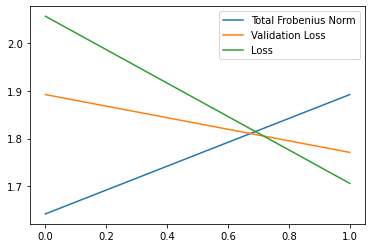

In [ ]:
plt.plot(dropout.history["total_frobenius_norm"]/np.max(dropout.history["total_frobenius_norm"]) * np.max(dropout.history["val_loss"]))
plt.plot(dropout.history["val_loss"])
plt.plot(dropout.history["loss"])
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
plt.savefig("convnet_dropout")
plt.show()

## 4. Training the same model with only batch normalization (batchnorm)

In [54]:
model = ConvModel(batch_norm=True)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer="adam")
batchnorm = model.fit(test_dataset, validation_data=test_dataset, epochs=2)

Epoch 1/2
312/313 [============================>.] - ETA: 0s - loss: 3.0909 - total_frobenius_norm: 48.4670 - accuracy: 0.3504

In [ ]:
plt.plot(batchnorm.history["total_frobenius_norm"]/np.max(batchnorm.history["total_frobenius_norm"]) * np.max(batchnorm.history["val_loss"]))
plt.plot(batchnorm.history["val_loss"])
plt.plot(batchnorm.history["loss"])
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
plt.savefig("convnet_batchnorm")
plt.show()

In [ ]:
# Initiate the logs and metrics
config_name= "config_name"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{config_name}/{current_time}/train"
val_log_path = f"logs/{config_name}/{current_time}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path)

# Initiate epochs and learning rate as global variables
epochs = 15
learning_rate = 0.05

# Define arrays for saving values for later visualization
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

### 2.3 Training

In [ ]:
# define the training loop

def training():

    # Select the model to use - the original or the modified one for optimization
    # network = BasicConv()
    network = ConvModel()

    # Train the model
    for epoch in range(epochs):
        print(f"Epoch: {epoch}, optimizer: {network.optimizer}")

        for data in tqdm.tqdm(train_dataset, position=0, leave=True):
            metrics = network.train_step(data)

            with train_summary_writer.as_default():
                for metric in network.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # print the end acc and loss
        print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "loss":
                train_losses.append(value.numpy())
            elif key == "acc":
                train_accuracies.append(value.numpy())

        # reset metrics for next round
        network.reset_metrics()

        # Testing
        for data in test_dataset:
            metrics = network.test_step(data)

            # log the accs and losses
            with val_summary_writer.as_default():
                for metric in network.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step = epoch)

        # print the end acc and loss
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "loss":
                val_losses.append(value.numpy())
            elif key == "acc":
                val_accuracies.append(value.numpy())

        # reset all metrics
        network.reset_metrics()

In [ ]:
# prepare the tensorboard ahead of training

%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
training()

### 2.4 - Visualization

In [ ]:
# visualize the results

fig = plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(val_losses)
line3, = plt.plot(train_accuracies)
line4, = plt.plot(val_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2,line3,line4),("Training Loss","Test Loss","Training Accuracy","Test Accuracy"))
fig.savefig("CNN Performance CIFAR-10")
plt.show()

## Report re Overfitting

Our original model overfit the data, as evidenced by the plateau in validation (testing) performance versus training. This discrepancy indicates it began to use features in the training data which did not help it generalize when it saw the new data in the test batch.

## Report re Optimization

We attempted the following optimization techniques and report on our reasoning for them and the results we obtained with them below:

0. original (no optimization applied)

1. L2 Regularization

2. Augmentation

3. Dropout

